To compare some of the aspects (ncells, density, depth, etc) between the $\Delta^{++} \longrightarrow \pi^+$ and pure $\pi^+$ sample 

In [1]:
#imports
import uproot as ur
import awkward as ak
import numpy as np
import pandas as pd

import os
os.environ['CUDA_VISIBLE_DEVICES'] = "7" #specify GPU
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

import tensorflow as tf

# energyflow imports
import energyflow as ef
from energyflow.archs import PFN
from energyflow.utils import data_split

from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

import graph_util_splitdelta as gu
import plot_util as pu

from scipy.interpolate import interp1d
import scipy.stats as stats

import Week7_PFNutils as W

import convert_sets_splitdelta as cs


2021-07-29 12:05:18.005479: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-07-29 12:05:30.174153: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-07-29 12:05:30.200543: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-07-29 12:05:30.360081: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1746] Found device 0 with properties: 
pciBusID: 0000:3d:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2021-07-29 12:05:30.360141: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-07-29 12:05:30.422684: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2

In [2]:
# metadata
layers = ["EMB1", "EMB2", "EMB3", "TileBar0", "TileBar1", "TileBar2"]#calorimeter layer names, B=barrel, EM = for EM showers, Tile=hadronic
cell_size_phi = [0.098, 0.0245, 0.0245, 0.1, 0.1, 0.1]#cell dimensions in these units
cell_size_eta = [0.0031, 0.025, 0.05, 0.1, 0.1, 0.2]
len_phi = [4, 16, 16, 4, 4, 4] #'image sizes' in phi/eta coords
len_eta = [128, 16, 8, 4, 4, 2]

In [3]:
import atlas_mpl_style as ampl #makes matplotlib follow atlas formal style
ampl.use_atlas_style()

In [75]:
#import all the pi+ data
path = '/fast_scratch/atlas_images/v7/'

branchpip = ['clusterIndex', 'truthE', 'nCluster', 'clusterE', 'clusterECalib','clusterPt', 'clusterEta', 
            'clusterPhi', 'cluster_nCells', 'cluster_sumCellE', 'cluster_ENG_CALIB_TOT', 'cluster_ENG_CALIB_OUT_T',
            'cluster_ENG_CALIB_DEAD_TOT', 'cluster_EM_PROBABILITY', 'cluster_HAD_WEIGHT', 'cluster_CENTER_MAG', 
            'cluster_FIRST_ENG_DENS', 'cluster_cellE_norm']
branchdel = ['cluster_hitsTruthE', 'cluster_hitsTruthIndex', 'nCluster', 'truthPartPdgId', 'cluster_nCells',
             'truthPartEta', 'truthPartPhi', 'cluster_FIRST_ENG_DENS', 'cluster_Phi',
         'truthPartPt', 'truthPartMass', 'cluster_E', 'cluster_Eta', 'cluster_CENTER_MAG','cluster_Pt']

pp_file = ur.open(path+'piplus.root') 
pp_tree = pp_file['ClusterTree']
pp = pd.DataFrame(pp_tree.arrays(expressions = branchpip, library='np')) 

In [76]:
model_path = '/fast_scratch/atlas_images/v01-45/' 
events = ur.open(model_path+'delta_medium.root')
tree = events['EventTree']

D = pd.DataFrame(tree.arrays(expressions=branchdel, library='np'))

In [77]:
ID = D['truthPartPdgId']

In [78]:
delpp = np.zeros(len(ID))
for i in range(len(ID)):
    if 2224 in ID[i]:
        delpp[i] = 2224

In [79]:
delppmask = delpp == 2224

In [80]:
delppmask

array([False, False,  True, ..., False, False,  True])

In [81]:
len(D), len(delppmask)

(200000, 200000)

In [82]:
D_pp = D[delppmask]

In [83]:
len(D_pp) #so cool that masking just works that way!!!! with dataframes!! This is sweet!!!!!!*****

25000

In [84]:
pp = pp[:len(D_pp)] #Just have them be the same length
len(pp)

25000

In [85]:
D_pp['cluster_E']

2         [40.48933, 30.217354, 24.075459, 16.14715, 13....
7         [113.96365, 45.717167, 8.253548, 5.7330704, 4....
14        [610.2678, 447.346, 416.4349, 16.847532, 9.415...
18                                    [852.2614, 2.7208242]
21        [635.2894, 261.48618, 23.62786, 20.249264, 11....
                                ...                        
199958    [21.977188, 14.112202, 13.16765, 3.9496453, 2....
199967                     [6.585341, 0.7403734, 0.7216046]
199982                                                   []
199993    [137.12135, 61.99141, 13.418747, 5.4440513, 1....
199999                                           [1.641062]
Name: cluster_E, Length: 25000, dtype: object

In [70]:
clusE_avg = []
for element in D_pp['cluster_E']:
    clusE_avg.append(np.mean(element))

/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


In [74]:
clusdepth_avg = []
for element in D_pp['cluster_CENTER_MAG']:
    clusdepth_avg.append(np.mean(element))

In [73]:
clusNcells_avg = []
for element in D_pp['cluster_nCells']:
    clusNcells_avg.append(np.mean(element))

/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [86]:
clusdens_avg = []
for element in D_pp['cluster_FIRST_ENG_DENS']:
    clusdens_avg.append(np.mean(element))

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


In [87]:
D_pp._set_item('cluster_E',clusE_avg) #this does work dont be scared
D_pp._set_item('cluster_CENTER_MAG', clusdepth_avg)
D_pp._set_item('cluster_nCells', clusNcells_avg)
D_pp._set_item('cluster_FIRST_ENG_DENS', clusdens_avg)

/tmp/ipykernel_32734/1103895526.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  D_pp._set_item('cluster_E',clusE_avg) #this does work dont be scared
/tmp/ipykernel_32734/1103895526.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  D_pp._set_item('cluster_CENTER_MAG', clusdepth_avg)
/tmp/ipykernel_32734/1103895526.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

In [55]:
D_pp['cluster_E']

2           9.420239
7          25.830078
14        250.138062
18        427.491119
21         53.836765
             ...    
199958      9.435941
199967      2.682440
199982           NaN
199993     27.750059
199999      1.641062
Name: cluster_E, Length: 25000, dtype: float32

<Figure size 799.992x599.976 with 0 Axes>

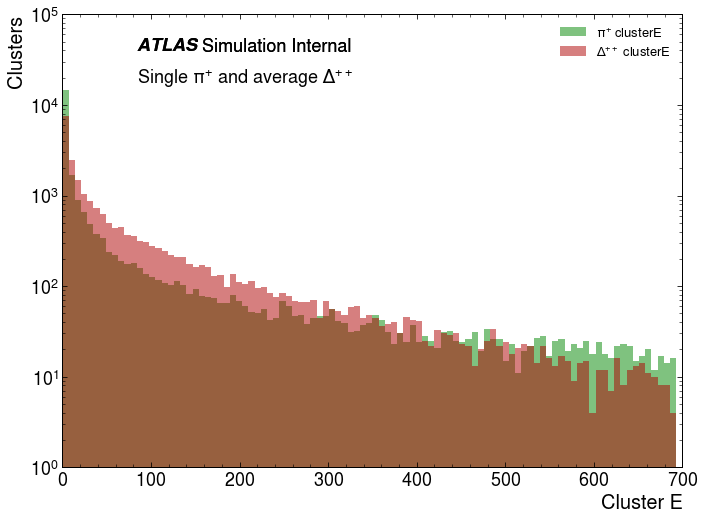

In [57]:
pu.histogramOverlay(frames = [pp, D_pp], #makes sense cause hadronic spread more, so would take up more cells!
                    data =  ['clusterE', 'cluster_E'], #vars to plot
                    labels =['$\pi^{+}$ clusterE', '$\Delta^{++}$ clusterE'],
                    xlabel = 'Cluster E',
                    ylabel = 'Clusters',
                    x_min = 0, x_max = 700, xbins = 100, normed = False, y_log = True,
                    atlas_x = 0.12, atlas_y = 0.95, simulation = True,
                    textlist = [{'x': 0.12, 'y': 0.85, 'text': 'Single $\pi^{+}$ and average $\Delta^{++}$'}])

<Figure size 799.992x599.976 with 0 Axes>

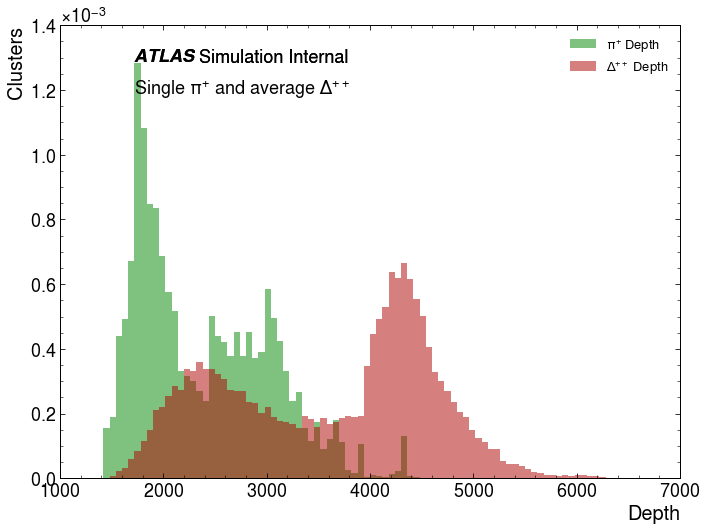

In [93]:
pu.histogramOverlay(frames = [pp, D_pp], #makes sense cause hadronic spread more, so would take up more cells!
                    data =  ['cluster_CENTER_MAG', 'cluster_CENTER_MAG'], #vars to plot
                    labels =['$\pi^{+}$ Depth', '$\Delta^{++}$ Depth'],
                    xlabel = 'Depth',
                    ylabel = 'Clusters',
                    x_min = 1000, x_max = 7000, xbins = 100, normed = True, y_log = False,
                    atlas_x = 0.12, atlas_y = 0.95, simulation = True,
                    textlist = [{'x': 0.12, 'y': 0.85, 'text': 'Single $\pi^{+}$ and average $\Delta^{++}$'}])

<Figure size 799.992x599.976 with 0 Axes>

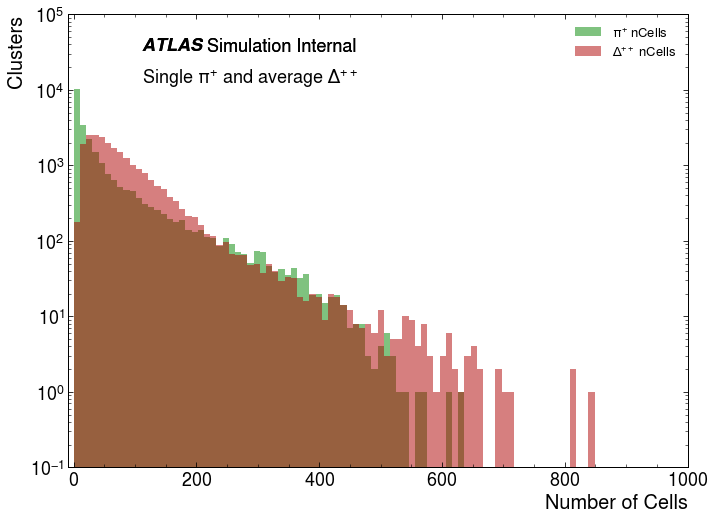

In [96]:
pu.histogramOverlay(frames = [pp, D_pp], #makes sense cause hadronic spread more, so would take up more cells!
                    data =  ['cluster_nCells', 'cluster_nCells'], #vars to plot
                    labels =['$\pi^{+}$ nCells', '$\Delta^{++}$ nCells'],
                    xlabel = 'Number of Cells',
                    ylabel = 'Clusters',
                    x_min = -10, x_max = 1000, xbins = 100, normed = False, y_log = True,
                    atlas_x = 0.12, atlas_y = 0.95, simulation = True,
                    textlist = [{'x': 0.12, 'y': 0.85, 'text': 'Single $\pi^{+}$ and average $\Delta^{++}$'}])

<Figure size 799.992x599.976 with 0 Axes>

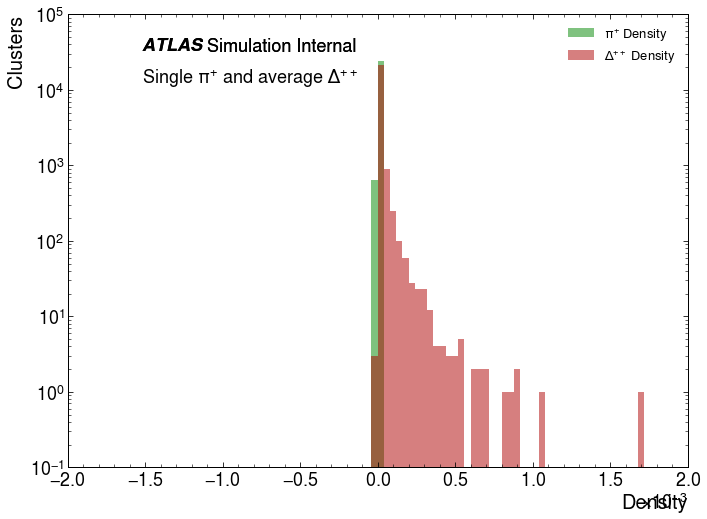

In [102]:
pu.histogramOverlay(frames = [pp, D_pp], #makes sense cause hadronic spread more, so would take up more cells!
                    data =  ['cluster_FIRST_ENG_DENS', 'cluster_FIRST_ENG_DENS'], #vars to plot
                    labels =['$\pi^{+}$ Density', '$\Delta^{++}$ Density'],
                    xlabel = 'Density',
                    ylabel = 'Clusters',
                    x_min = -.002, x_max = .002, xbins = 100, normed = False, y_log = True,
                    atlas_x = 0.12, atlas_y = 0.95, simulation = True,
                    textlist = [{'x': 0.12, 'y': 0.85, 'text': 'Single $\pi^{+}$ and average $\Delta^{++}$'}])